In [ ]:
# !pip install tensorflow-privacy
# !pip install --upgrade tensorflow-estimator==2.3.0
# !pip install --upgrade tensorflow==2.14.0
# !pip install deap

In [ ]:
# !pip install imblearn

In [1]:
# =========================
# Standard Library
# =========================
import os
import random
import time
import warnings

# =========================
# Third-Party: Numerical / Data
# =========================
import numpy as np
import pandas as pd

# =========================
# Third-Party: Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Third-Party: sklearn
# =========================
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.utils import resample, shuffle
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    auc,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
)

# =========================
# Third-Party: Imbalanced-Learn
# =========================
from imblearn.over_sampling import RandomOverSampler

# =========================
# Third-Party: TensorFlow & Privacy
# =========================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import (
    TruePositives,
    TrueNegatives,
    FalsePositives,
    FalseNegatives,
)

import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

# =========================
# Third-Party: Genetic Algorithm (DEAP)
# =========================
from deap import base, creator, tools

# =========================
# Warnings
# =========================
warnings.filterwarnings("ignore", category=UserWarning)


## Load and Preprocess Data

In [2]:
data = pd.read_csv(r'\Users\dmachooka\Downloads\dmac\BotNeTIoT-L01_label_NoDuplicates.csv', index_col = 0)

In [3]:
# Binary problem
target_column = 'label'
display(data[target_column].unique())
num_classes = data[target_column].nunique()

array([0, 1], dtype=int64)

In [4]:
# Identify non-numeric columns (there are none)
print(data.select_dtypes(include='object').columns)

Index([], dtype='object')


In [5]:
categorical_columns = [col for col in data.columns if col not in [target_column]] # Other columns

X = data.drop(target_column, axis=1)
y = data[target_column]

# Split into training test and validation datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)



# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

In [6]:
# Function to plot loss curves
def plot_loss(history1, history2=None):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values for the first model
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values for the first model
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    if history2 is not None:
        # Plot training & validation loss values for the second model
        plt.subplot(1, 2, 1)
        plt.plot(history2.history['loss'], linestyle='dashed')
        plt.plot(history2.history['val_loss'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='upper right')

        # Plot training & validation accuracy values for the second model
        plt.subplot(1, 2, 2)
        plt.plot(history2.history['accuracy'], linestyle='dashed')
        plt.plot(history2.history['val_accuracy'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='lower right')

    plt.tight_layout()
    plt.show()

## Privacy

In [7]:
gene_alg = True
# --- Define parameter space ---
ACTIVATIONS = ['gelu', 'swish', 'silu', 'relu']
OPTIMIZERS = ['sgd', 'adam']
LOSSES = ['binary_crossentropy']
LEARNING_RATES = [0.001, 0.0001]
BATCH_SIZES = [128, 256]
EPOCHS = [10, 23, 30, 50, 100]
UNITS = [32, 64, 128]
MAX_LAYERS = 6

In [8]:
def evaluate_nn_with_dp(hyperparams):
    units = hyperparams['units']
    dropouts = hyperparams['dropouts']
    learning_rate = hyperparams['learning_rate']

    # Define MLP model with DP
    mlp_model_privacy = tf.keras.Sequential([
        Dense(units=units[0], activation='relu', input_shape=(len(categorical_columns),)),
        Dropout(rate=dropouts[0]),
        Dense(units=units[1], activation='relu'),
        Dropout(rate=dropouts[1]),
        Dense(2, activation='sigmoid')
    ])

    # Define differential privacy optimizer
    optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
        l2_norm_clip=1.0,
        noise_multiplier=1.3,
        num_microbatches=1,
        learning_rate=learning_rate
    )

    # Compile the model with the DP optimizer and loss function
    mlp_model_privacy.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Perform 5-fold cross-validation
    kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    cv_results = []

    for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
        X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Convert labels to categorical
        y_train_fold2 = tf.keras.utils.to_categorical(y_train_fold, num_classes=2)
        y_val_fold2 = tf.keras.utils.to_categorical(y_val_fold, num_classes=2)

        # Train the model on the current fold
        mlp_model_privacy.fit(X_train_fold, y_train_fold2, epochs=10, batch_size=16, verbose=0)
        # _, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        # cv_results.append(val_accuracy)
        # Predict class labels for F1
        y_pred_proba = mlp_model_privacy.predict(X_val_fold, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)   # convert softmax → class

        # Compute F1
        f1 = f1_score(y_val_fold2, y_pred, average="binary")  # or "macro", "weighted"
        cv_results.append(f1)

    # Extract trainable variables from the model
    trainable_variables = mlp_model_privacy.trainable_variables

    # Compute privacy budget
    privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
        number_of_examples=len(X_train_scaled),
        # batch_size=batch_size,
        noise_multiplier=1.3,
        num_epochs=30,
        delta=1e-5
    )

    epsilon = None

    # Case A: report is an object with epsilon attr
    if hasattr(privacy_report, "epsilon"):
        epsilon = privacy_report.epsilon

    # Case B: report is a tuple (epsilon, something)
    elif isinstance(privacy_report, tuple) and len(privacy_report) >= 1 and isinstance(privacy_report[0], (float, int)):
        epsilon = privacy_report[0]

    # Case C: report is a string
    elif isinstance(privacy_report, str):
        import re
        match = re.search(r"epsilon[^0-9]*([0-9.]+)", privacy_report.lower())
        if match:
            epsilon = float(match.group(1))

    score = np.mean(cv_results) - epsilon # GA maximizes score by default

    return score,

In [9]:
def custom_crossover(ind1, ind2):
    """Two-point crossover"""
    keys = list(ind1.keys())
    cx1, cx2 = sorted([random.randint(1, len(keys)-1) for _ in range(2)])
    for i in range(cx1, cx2):
        key = keys[i]
        ind1[key], ind2[key] = ind2[key], ind1[key]
    return ind1, ind2

def custom_mutation(ind):
    """Random mutation of one hyperparameter"""
    param = random.choice(list(ind.keys()))
    if param == 'units':
        n_layers = len(ind['units'])
        ind['units'] = [random.choice(UNITS) for _ in range(n_layers)]
    elif param == 'dropouts':
        ind['dropouts'] = [random.uniform(0.1, 0.5) for _ in range(len(ind['dropouts']))]
    elif param == 'activation':
        ind['activation'] = random.choice(ACTIVATIONS)
    elif param == 'optimizer':
        ind['optimizer'] = random.choice(OPTIMIZERS)
    elif param == 'loss':
        ind['loss'] = random.choice(LOSSES)
    elif param == 'learning_rate':
        ind['learning_rate'] = random.choice(LEARNING_RATES)
    elif param == 'batch_size':
        ind['batch_size'] = random.choice(BATCH_SIZES)
    elif param == 'epochs':
        ind['epochs'] = random.choice(EPOCHS)
    return ind,

In [10]:
def create_hyperparameter_set():
    return {
        'units': [random.choice([32, 64, 128]) for _ in range(2)],  # 2 layers
        'dropouts': [random.uniform(0.1, 0.5) for _ in range(2)],   # 2 dropout rates
        'learning_rate': random.uniform(0.0001, 0.01)
        'epochs': random.choice(EPOCHS_CHOICES),
        'batch_size': random.choice(BATCH_SIZES)
    }

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", dict, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_hyperparameter_set)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", custom_crossover)
toolbox.register("mutate", tools.mutUniformInt, low=32, up=128, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_nn_with_dp)
toolbox.register("batch_size", random.choice, BATCH_SIZES)

In [11]:
def genetic_algorithm():
    pop = toolbox.population(n=10)
    ngen = 5  # Number of generations
    cxpb, mutpb = 0.5, 0.2  # Crossover and mutation probabilities

    for gen in range(ngen):
        print(f"-- Generation {gen} --")

        # Evaluate all individuals
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # Select individuals for the next generation
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring

    # Return the best individual
    top_individual = tools.selBest(pop, 1)[0]
    return top_individual

In [12]:
gene_alg = False
if gene_alg:
  best_hyperparameters = genetic_algorithm()
  print("Best Hyperparameters:", best_hyperparameters)

In [13]:
if gene_alg:
  best_hp = {
    'units': best_hyperparameters['units'],
    'dropouts': best_hyperparameters['dropouts'],
    'learning_rate': best_hyperparameters['learning_rate']
  }
else:
  best_hp = {
    'units': [32, 32],
    'dropouts': [0.22000304274500324, 0.38010501321219803],
    'learning_rate': 0.009732276353368684
}

# Build the final MLP model with the best hyperparameters
mlp_model_privacy = tf.keras.Sequential([
    Dense(units=best_hp['units'][0], activation='relu', input_shape=(len(categorical_columns),)),
    Dropout(rate=best_hp['dropouts'][0]),
    Dense(units=best_hp['units'][1], activation='relu'),
    Dropout(rate=best_hp['dropouts'][1]),
    Dense(2, activation='sigmoid')
])

# Create a DP optimizer with the best learning rate
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=1.3,
    num_microbatches=1,
    learning_rate=best_hp['learning_rate']
)

# Compile the model
mlp_model_privacy.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv_results = []

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Convert labels to categorical
    y_train_fold2 = tf.keras.utils.to_categorical(y_train_fold, num_classes=2)
    y_val_fold2 = tf.keras.utils.to_categorical(y_val_fold, num_classes=2)

    # Train the model on the current fold
    mlp_model_privacy.fit(X_train_fold, y_train_fold2, epochs=30, batch_size=16, verbose=1)
    val_loss, val_accuracy = mlp_model_privacy.evaluate(X_val_fold, y_val_fold2, verbose=0)
    cv_results.append([val_loss, val_accuracy])

# Fit the final model to the full training data
y_train_full = tf.keras.utils.to_categorical(y_train, num_classes=2)
best_hp['noise_multiplier'] = 1.2166580937239728
model_history_privacy = mlp_model_privacy.fit(X_train_scaled[categorical_columns], y_train_full,
              epochs=30, validation_split=0.2, batch_size=16)

# Predict on test data
y_test_pred_mlp_privacy = mlp_model_privacy.predict(X_test_scaled[categorical_columns])

# Apply the threshold to make binary predictions
threshold = 0.8
y_test_pred_binary_privacy_mlp = (y_test_pred_mlp_privacy > threshold).astype(int)

Epoch 1/30
94788/94788 [==============================] - 239s 2ms/step - loss: 21.9909 - accuracy: 0.9646
Epoch 2/30
94788/94788 [==============================] - 251s 3ms/step - loss: 52.4225 - accuracy: 0.9845
Epoch 3/30
94788/94788 [==============================] - 222s 2ms/step - loss: 87.4001 - accuracy: 0.9884
Epoch 4/30
94788/94788 [==============================] - 196s 2ms/step - loss: 121.7690 - accuracy: 0.9882
Epoch 5/30
94788/94788 [==============================] - 249s 3ms/step - loss: 129.0503 - accuracy: 0.9881
Epoch 6/30
94788/94788 [==============================] - 263s 3ms/step - loss: 214.9485 - accuracy: 0.9864
Epoch 7/30
94788/94788 [==============================] - 267s 3ms/step - loss: 170.7231 - accuracy: 0.9881
Epoch 8/30
94788/94788 [==============================] - 265s 3ms/step - loss: 261.7102 - accuracy: 0.9848
Epoch 9/30
94788/94788 [==============================] - 260s 3ms/step - loss: 285.9103 - accuracy: 0.9637
Epoch 10/30
94788/94788 [======

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94788/94788 [==============================] - 222s 2ms/step - loss: 1422.8302 - accuracy: 0.9492
Epoch 23/30
59870/94788 [=================>............] - ETA: 1:22 - loss: 1426.0743 - accuracy: 0.9279

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94788/94788 [==============================] - 225s 2ms/step - loss: 1750.4271 - accuracy: 0.9223
Epoch 1/30
 4677/94788 [>.............................] - ETA: 3:45 - loss: 1954.1089 - accuracy: 0.9100

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94788/94788 [==============================] - 216s 2ms/step - loss: 2050.7756 - accuracy: 0.8696
Epoch 8/30
50265/94788 [==============>...............] - ETA: 1:40 - loss: 1844.7351 - accuracy: 0.8742

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94788/94788 [==============================] - 216s 2ms/step - loss: 2023.6348 - accuracy: 0.9143
Epoch 16/30
36858/94788 [==========>...................] - ETA: 2:15 - loss: 1850.4166 - accuracy: 0.9102

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



83637/94788 [=========================>....] - ETA: 26s - loss: 2173.0457 - accuracy: 0.8643

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



78424/94788 [=======================>......] - ETA: 39s - loss: 2320.5488 - accuracy: 0.8565

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94788/94788 [==============================] - 276s 3ms/step - loss: 2941.3474 - accuracy: 0.8561
Epoch 1/30
 7351/94788 [=>............................] - ETA: 4:16 - loss: 3279.6316 - accuracy: 0.8577

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



87778/94788 [==========================>...] - ETA: 20s - loss: 3450.6213 - accuracy: 0.8566

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94788/94788 [==============================] - 276s 3ms/step - loss: 3584.1975 - accuracy: 0.8432
Epoch 7/30
 6050/94788 [>.............................] - ETA: 3:51 - loss: 3900.0566 - accuracy: 0.8394

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



79551/94788 [========================>.....] - ETA: 44s - loss: 4395.2534 - accuracy: 0.8507

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



75924/94788 [=======================>......] - ETA: 54s - loss: 4540.4604 - accuracy: 0.8595

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94788/94788 [==============================] - 208s 2ms/step - loss: 4864.5410 - accuracy: 0.8582
Epoch 17/30
16995/94788 [====>.........................] - ETA: 2:51 - loss: 5125.5620 - accuracy: 0.8654

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



84103/94788 [=========================>....] - ETA: 23s - loss: 4386.0767 - accuracy: 0.8446

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



55341/94788 [================>.............] - ETA: 1:30 - loss: 3966.9832 - accuracy: 0.8410

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



75396/94788 [======================>.......] - ETA: 50s - loss: 4564.3511 - accuracy: 0.8424

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94788/94788 [==============================] - 249s 3ms/step - loss: 4994.0483 - accuracy: 0.8493
Epoch 1/30
15807/94789 [====>.........................] - ETA: 4:00 - loss: 4419.1050 - accuracy: 0.8488

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94789/94789 [==============================] - 290s 3ms/step - loss: 4247.0298 - accuracy: 0.8397
Epoch 3/30
11999/94789 [==>...........................] - ETA: 4:11 - loss: 4549.1182 - accuracy: 0.8531

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



64410/94789 [===================>..........] - ETA: 1:32 - loss: 4860.4297 - accuracy: 0.8538

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



61322/94789 [==================>...........] - ETA: 1:42 - loss: 4980.3296 - accuracy: 0.8613

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



31737/94789 [=========>....................] - ETA: 2:29 - loss: 5979.6792 - accuracy: 0.8532

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



90700/94789 [===========================>..] - ETA: 9s - loss: 6851.1948 - accuracy: 0.8714

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



43445/94789 [============>.................] - ETA: 1:59 - loss: 6045.4761 - accuracy: 0.9105

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94789/94789 [==============================] - 222s 2ms/step - loss: 5136.5464 - accuracy: 0.8908
Epoch 22/30
33368/94789 [=========>....................] - ETA: 2:23 - loss: 5185.4517 - accuracy: 0.8888

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



92214/94789 [============================>.] - ETA: 5s - loss: 4838.4971 - accuracy: 0.8954

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94776/94789 [============================>.] - ETA: 0s - loss: 4993.8218 - accuracy: 0.8663

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



61858/94789 [==================>...........] - ETA: 1:20 - loss: 6812.9517 - accuracy: 0.8550

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94789/94789 [==============================] - 241s 3ms/step - loss: 5773.2148 - accuracy: 0.8559
Epoch 7/30
26329/94789 [=======>......................] - ETA: 2:54 - loss: 6570.8311 - accuracy: 0.8476

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



94789/94789 [==============================] - 240s 3ms/step - loss: 6539.0742 - accuracy: 0.8423
Epoch 9/30
22394/94789 [======>.......................] - ETA: 3:04 - loss: 5923.5034 - accuracy: 0.8471

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



83204/94789 [=========================>....] - ETA: 29s - loss: 5659.2153 - accuracy: 0.8501

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



90043/94789 [===========================>..] - ETA: 12s - loss: 5328.1626 - accuracy: 0.8407

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



70549/94789 [=====================>........] - ETA: 52s - loss: 6326.5430 - accuracy: 0.8528

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



83007/94789 [=========================>....] - ETA: 25s - loss: 6805.3555 - accuracy: 0.8485

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



58344/94789 [=================>............] - ETA: 1:22 - loss: 6077.3003 - accuracy: 0.8401

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



49137/90997 [===============>..............] - ETA: 1:34 - loss: 7289.1431 - accuracy: 0.8496

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



90997/90997 [==============================] - 238s 3ms/step - loss: 7900.3198 - accuracy: 0.8487 - val_loss: 2797.5085 - val_accuracy: 0.8168
Epoch 4/30
29002/90997 [========>.....................] - ETA: 2:19 - loss: 8955.8857 - accuracy: 0.8460

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



55570/90997 [=================>............] - ETA: 1:16 - loss: 8404.2295 - accuracy: 0.8340

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



45398/90997 [=============>................] - ETA: 1:37 - loss: 8482.2744 - accuracy: 0.8416

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



47450/90997 [==============>...............] - ETA: 1:39 - loss: 10285.5967 - accuracy: 0.8339

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



89917/90997 [============================>.] - ETA: 2s - loss: 8005.1733 - accuracy: 0.8480

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



90997/90997 [==============================] - 234s 3ms/step - loss: 9341.3711 - accuracy: 0.8382 - val_loss: 4658.5273 - val_accuracy: 0.8527
Epoch 25/30
18102/90997 [====>.........................] - ETA: 2:42 - loss: 10162.9141 - accuracy: 0.8394

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



65942/90997 [====================>.........] - ETA: 55s - loss: 9703.1182 - accuracy: 0.8392

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [14]:
# Predict on the test data
y_test_pred_mlp_privacy = mlp_model_privacy.predict(X_test_scaled[categorical_columns])

# # Apply the threshold to make binary predictions
y_test_pred_binary_mlp_privacy = y_test_pred_mlp_privacy.argmax(axis=1)

7584/7584 [==============================] - 11s 1ms/step


In [15]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp_privacy = accuracy_score(y_test, y_test_pred_binary_mlp_privacy)
precision_mlp_privacy = precision_score(y_test, y_test_pred_binary_mlp_privacy)
recall_mlp_privacy = recall_score(y_test, y_test_pred_binary_mlp_privacy)
f1_mlp_privacy = f1_score(y_test, y_test_pred_binary_mlp_privacy)

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp_privacy}")
print(f"Precision = {precision_mlp_privacy}")
print(f"Recall = {recall_mlp_privacy}")
print(f"F1 Score =  {f1_mlp_privacy}")

Average cross-validation loss: 1285.2677357991536
Average cross-validation accuracy: 0.8997142215569814
MLP Model:
Accuracy =  0.8604950176792028
Precision = 0.998053583695901
Recall = 0.34016233512838523
F1 Score =  0.5073923166472643


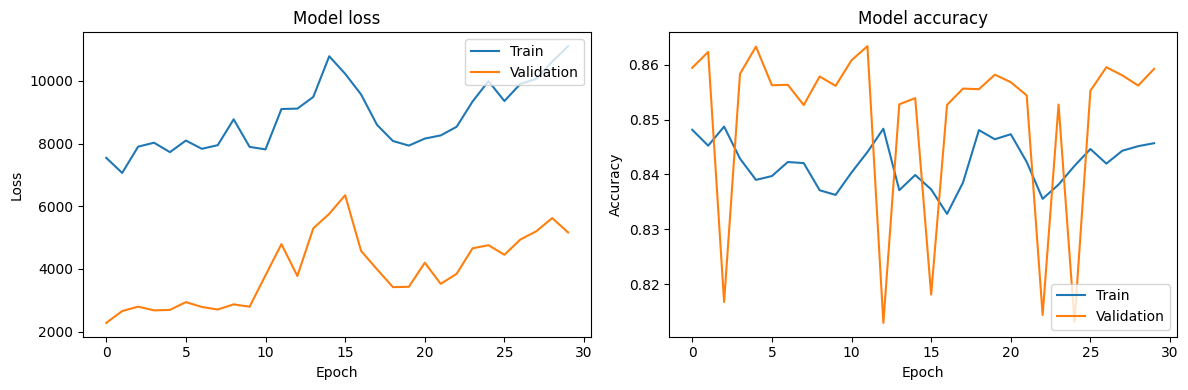

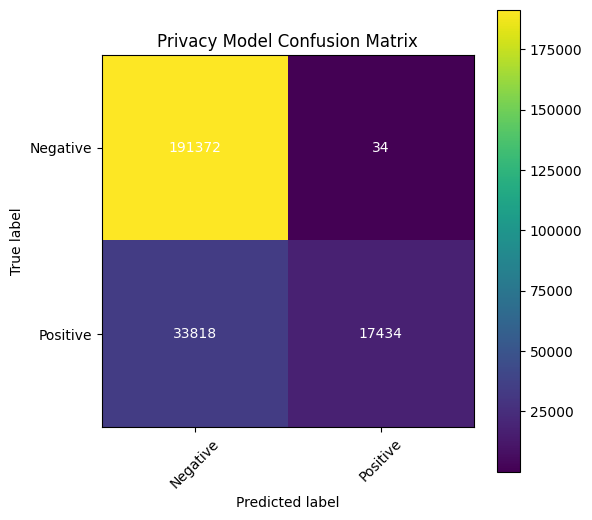

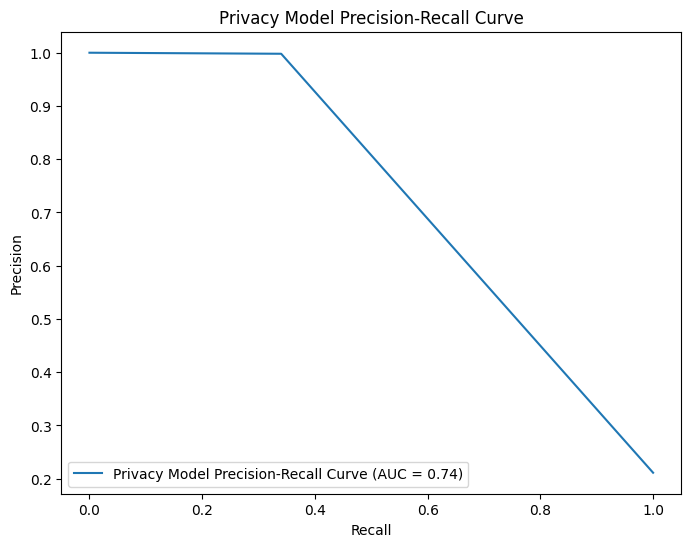

In [16]:
# Plot loss curves
plot_loss(model_history_privacy)

# Confusion Matrix
y_test_binary_true = y_test
y_test_binary_pred = y_test_pred_binary_mlp_privacy
conf_matrix = confusion_matrix(y_test_binary_true, y_test_binary_pred)

plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest')

plt.title('Privacy Model Confusion Matrix')
plt.colorbar()
classes = ['Negative', 'Positive']
tick_marks = [0, 1]
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='w')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_binary_mlp_privacy)
area_under_curve = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Privacy Model Precision-Recall Curve (AUC = {area_under_curve:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Privacy Model Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [17]:
# Extract trainable variables from the model
trainable_variables = mlp_model_privacy.trainable_variables

# Compute privacy budget
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_scaled),
    batch_size=32,
    noise_multiplier=1.3,
    num_epochs=30,
    delta=1e-5
)

In [18]:
print(privacy_report)

DP-SGD performed over 1819930 examples with 32 examples per iteration, noise
multiplier 1.3 for 30 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        74.229
    Epsilon assuming Poisson sampling (*):                      1.140

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.

